## 1. Import Libraries

In [ ]:
import numpy as np
import pandas as pd
import json
import os
from glob import glob
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import f1_score, classification_report, confusion_matrix
from sklearn.impute import SimpleImputer
from catboost import CatBoostClassifier
import matplotlib.pyplot as plt
import seaborn as sns


np.random.seed(42)

## 2. Define Paths

In [2]:

csv_path = 'train_air_respiratory.csv'
cough_path = 'dataclean_cough_mfcc/'
vowel_path = 'dataclean_vowel_mfcc/'

print(f"CSV Path: {csv_path}")
print(f"Cough Path: {cough_path}")
print(f"Vowel Path: {vowel_path}")
print(f"Cough folder exists: {os.path.exists(cough_path)}")
print(f"Vowel folder exists: {os.path.exists(vowel_path)}")

CSV Path: train_air_respiratory.csv
Cough Path: dataclean_cough_mfcc/
Vowel Path: dataclean_vowel_mfcc/
Cough folder exists: True
Vowel folder exists: True


## 3. Load & Explore CSV Data

In [3]:
# Load CSV
df = pd.read_csv(csv_path)

print("Dataset Shape:", df.shape)
print("\nFirst 5 rows:")
print(df.head())
print("\nData Info:")
print(df.info())
print("\nMissing Values:")
print(df.isnull().sum())
print("\nTarget Distribution:")
print(df['disease'].value_counts())

Dataset Shape: (546, 11)

First 5 rows:
     candidateID  age  gender  tbContactHistory  wheezingHistory  phlegmCough  \
0  b87ea0dd760fa   43       1               0.0              1.0          0.0   
1  b734834dec6d1   24       0               0.0              1.0          0.0   
2  e000a41725f53   52       1               0.0              1.0          0.0   
3  253ba780a0398   28       0               0.0              0.0          0.0   
4  6663cd023ff3d   27       1               0.0              1.0          0.0   

   familyAsthmaHistory  feverHistory  coldPresent  packYears  disease  
0                  0.0             0          NaN          0        1  
1                  0.0             0          NaN          0        1  
2                  0.0             0          NaN          0        2  
3                  0.0             0          NaN          0        0  
4                  1.0             0          NaN          0        1  

Data Info:
<class 'pandas.core.frame.Dat

## 4. Explore Audio Embedding Data Structure

In [ ]:

cough_folders = glob(cough_path + '*/')
vowel_folders = glob(vowel_path + '*/')
print(f"Total cough candidate folders: {len(cough_folders)}")
print(f"Total vowel candidate folders: {len(vowel_folders)}")
print(f"\nContoh folder cough pertama: {cough_folders[0]}")
print(f"Contoh folder vowel pertama: {vowel_folders[0]}")

# Cek isi folder pertama cough
example_cough_folder = cough_folders[0]
files_in_cough_folder = os.listdir(example_cough_folder)
print(f"\nFiles in {example_cough_folder}:")
for f in files_in_cough_folder:
    print(f"  - {f}")

# Load contoh embedding (mfcc_features.json)
example_cough = json.load(open(os.path.join(example_cough_folder, 'mfcc_features.json')))
example_vowel_folder = vowel_folders[0]
example_vowel = json.load(open(os.path.join(example_vowel_folder, 'mfcc_features.json')))

print(f"\nCough embeddings:")
print(f"  - Type: {type(example_cough)}")
print(f"  - Content preview: {str(example_cough)[:200]}")

print(f"\nVowel embeddings:")
print(f"  - Type: {type(example_vowel)}")
print(f"  - Content preview: {str(example_vowel)[:200]}")


Total cough candidate folders: 876
Total vowel candidate folders: 869

Contoh folder cough pertama: dataclean_cough_mfcc\004db89f19f9b\
Contoh folder vowel pertama: dataclean_vowel_mfcc\004db89f19f9b\

Files in dataclean_cough_mfcc\004db89f19f9b\:
  - mfcc_features.json

Cough embeddings:
  - Type: <class 'dict'>
  - Content preview: {'audio_path': '/mnt/ml_storage/Final_Project/SOURCE2/dataclean_cough/004db89f19f9b/cough.wav', 'sample_rate': 16000, 'duration': 1.0, 'n_mfcc': 13, 'features': {'mfcc': [[-360.0908508300781, -358.246

Vowel embeddings:
  - Type: <class 'dict'>
  - Content preview: {'audio_path': '/mnt/ml_storage/Final_Project/SOURCE2/dataclean_vowel/004db89f19f9b/vowel.wav', 'sample_rate': 16000, 'duration': 1.0, 'n_mfcc': 13, 'features': {'mfcc': [[-339.2197265625, -286.096771

Files in dataclean_cough_mfcc\004db89f19f9b\:
  - mfcc_features.json

Cough embeddings:
  - Type: <class 'dict'>
  - Content preview: {'audio_path': '/mnt/ml_storage/Final_Project/SOURCE2/dataclea

## 5. Match IDs: Audio Embeddings ↔ CSV

Matching candidateID dari folder audio embeddings dengan candidateID di CSV untuk memastikan data alignment.

In [5]:
# Extract candidate IDs dari cough dan vowel folders
cough_candidate_ids = set()
for folder in cough_folders:
    candidate_id = os.path.basename(folder.rstrip('/\\'))
    cough_candidate_ids.add(candidate_id)

vowel_candidate_ids = set()
for folder in vowel_folders:
    candidate_id = os.path.basename(folder.rstrip('/\\'))
    vowel_candidate_ids.add(candidate_id)

# Union of both (candidates with at least one audio type)
audio_candidate_ids = cough_candidate_ids.union(vowel_candidate_ids)

print(f"Total unique candidate IDs in cough folder: {len(cough_candidate_ids)}")
print(f"Total unique candidate IDs in vowel folder: {len(vowel_candidate_ids)}")
print(f"Total unique candidate IDs with audio: {len(audio_candidate_ids)}")

# Extract candidate IDs dari CSV
csv_candidate_ids = set(df['candidateID'].unique())
print(f"Total unique candidate IDs in CSV: {len(csv_candidate_ids)}")

# Find matches
matched_ids = audio_candidate_ids.intersection(csv_candidate_ids)
print(f"\nMatched IDs (exist in both): {len(matched_ids)}")

# IDs only in audio folders
only_in_audio = audio_candidate_ids - csv_candidate_ids
print(f"IDs only in audio folders: {len(only_in_audio)}")

# IDs only in CSV
only_in_csv = csv_candidate_ids - audio_candidate_ids
print(f"IDs only in CSV: {len(only_in_csv)}")

print(f"\nContoh matched IDs (5 pertama): {list(matched_ids)[:5]}")

Total unique candidate IDs in cough folder: 876
Total unique candidate IDs in vowel folder: 869
Total unique candidate IDs with audio: 877
Total unique candidate IDs in CSV: 544

Matched IDs (exist in both): 539
IDs only in audio folders: 338
IDs only in CSV: 5

Contoh matched IDs (5 pertama): ['d663a18f554ff', '634f8e8e79d9a', '5b0578b39385f', '4b66275894272', '7d311de4a644b']


## 6. Load & Prepare Features

### 6.1 Function untuk Load Embeddings

In [ ]:
def load_mean_embedding_mfcc(folder_path, emb_type='cough'):
 
    mfcc_path = os.path.join(folder_path, 'mfcc_features.json')
    
    if not os.path.exists(mfcc_path):
        return None
    
    try:
        with open(mfcc_path, 'r') as f:
            data = json.load(f)
        
        # Handle nested dict structure: {'features': {'mfcc': [...]}}
        if isinstance(data, dict) and 'features' in data and 'mfcc' in data['features']:
            arr = np.asarray(data['features']['mfcc'], dtype=np.float32)
        # Handle dict with 'mfcc' key directly
        elif isinstance(data, dict) and 'mfcc' in data:
            arr = np.asarray(data['mfcc'], dtype=np.float32)
        # Handle list format (legacy)
        elif isinstance(data, list):
            arr = np.asarray(data, dtype=np.float32)
        else:
            return None
        
        # Mean-pool if 2D, otherwise keep as 1D
        if arr.ndim == 2:
            emb = arr.mean(axis=0)
        elif arr.ndim == 1:
            emb = arr
        else:
            return None
        
        return emb
    except Exception as e:
        return None


def load_embeddings_for_candidates(matched_ids, emb_type='cough'):
    embeddings_dict = {}
    missing_count = 0
    
    # Select the appropriate folder path
    folder_path = cough_path if emb_type == 'cough' else vowel_path
    
    for cand_id in matched_ids:
        cand_folder = os.path.join(folder_path, cand_id)
        emb = load_mean_embedding_mfcc(cand_folder, emb_type)
        
        if emb is not None:
            embeddings_dict[cand_id] = emb
        else:
            missing_count += 1
    
    print(f"\n{emb_type.capitalize()} Embeddings:")
    print(f"  - Successfully loaded: {len(embeddings_dict)}")
    print(f"  - Missing/Error: {missing_count}")
    
    return embeddings_dict


### 6.2 Load All Embeddings

In [7]:
cough_embeddings = load_embeddings_for_candidates(matched_ids, emb_type='cough')
vowel_embeddings = load_embeddings_for_candidates(matched_ids, emb_type='vowel')


Cough Embeddings:
  - Successfully loaded: 538
  - Missing/Error: 1

Vowel Embeddings:
  - Successfully loaded: 533
  - Missing/Error: 6

Vowel Embeddings:
  - Successfully loaded: 533
  - Missing/Error: 6


### 6.3 Combine Features: Tabular + Audio Embeddings

In [8]:
# Filter dataframe untuk hanya kandidat yang punya embeddings lengkap
candidates_with_both = set(cough_embeddings.keys()).intersection(set(vowel_embeddings.keys()))
print(f"Candidates with both cough AND vowel embeddings: {len(candidates_with_both)}")

# Filter CSV untuk kandidat yang punya embeddings lengkap
df_filtered = df[df['candidateID'].isin(candidates_with_both)].copy()
print(f"Filtered dataframe shape: {df_filtered.shape}")

# Sort by candidateID untuk consistency
df_filtered = df_filtered.sort_values('candidateID').reset_index(drop=True)

print("\nFiltered target distribution:")
print(df_filtered['disease'].value_counts())

Candidates with both cough AND vowel embeddings: 532
Filtered dataframe shape: (533, 11)

Filtered target distribution:
disease
1    238
2    158
0    137
Name: count, dtype: int64


In [9]:
# Prepare tabular features
# Drop candidateID dan disease (target)
tabular_features = df_filtered.drop(columns=['candidateID', 'disease'])

# Handle missing values
imputer = SimpleImputer(strategy='most_frequent')
tabular_features_imputed = imputer.fit_transform(tabular_features)

print(f"Tabular features shape: {tabular_features_imputed.shape}")
print(f"Feature names: {list(tabular_features.columns)}")

Tabular features shape: (533, 9)
Feature names: ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 'phlegmCough', 'familyAsthmaHistory', 'feverHistory', 'coldPresent', 'packYears']


In [10]:
# Prepare audio embeddings (cough + vowel)
cough_features = []
vowel_features = []

for cand_id in df_filtered['candidateID']:
    cough_features.append(cough_embeddings[cand_id])
    vowel_features.append(vowel_embeddings[cand_id])

cough_features = np.array(cough_features)
vowel_features = np.array(vowel_features)

print(f"Cough features shape: {cough_features.shape}")
print(f"Vowel features shape: {vowel_features.shape}")

Cough features shape: (533, 63)
Vowel features shape: (533, 63)


In [11]:
# Concatenate ALL features: Tabular + Cough + Vowel
X_combined = np.concatenate([
    tabular_features_imputed,
    cough_features,
    vowel_features
], axis=1)

y = df_filtered['disease'].values

print(f"\n=== COMBINED FEATURES ===")
print(f"X_combined shape: {X_combined.shape}")
print(f"  - Tabular features: {tabular_features_imputed.shape[1]}")
print(f"  - Cough embeddings: {cough_features.shape[1]}")
print(f"  - Vowel embeddings: {vowel_features.shape[1]}")
print(f"  - Total features: {X_combined.shape[1]}")
print(f"\ny (target) shape: {y.shape}")


=== COMBINED FEATURES ===
X_combined shape: (533, 135)
  - Tabular features: 9
  - Cough embeddings: 63
  - Vowel embeddings: 63
  - Total features: 135

y (target) shape: (533,)


## 7. Split Data: Train & Test

In [12]:
# Split 80% train, 20% test
X_train, X_test, y_train, y_test = train_test_split(
    X_combined, y, 
    test_size=0.2, 
    random_state=42, 
    stratify=y  
)

print("Train set:")
print(f"  X_train shape: {X_train.shape}")
print(f"  y_train shape: {y_train.shape}")
print(f"  Class distribution: {np.bincount(y_train)}")

print("\nTest set:")
print(f"  X_test shape: {X_test.shape}")
print(f"  y_test shape: {y_test.shape}")
print(f"  Class distribution: {np.bincount(y_test)}")

Train set:
  X_train shape: (426, 135)
  y_train shape: (426,)
  Class distribution: [110 190 126]

Test set:
  X_test shape: (107, 135)
  y_test shape: (107,)
  Class distribution: [27 48 32]


## 8. Feature Scaling 

In [13]:
# Standardize features (mean=0, std=1)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Scaled data statistics:")
print(f"X_train_scaled mean: {X_train_scaled.mean():.4f}")
print(f"X_train_scaled std: {X_train_scaled.std():.4f}")

Scaled data statistics:
X_train_scaled mean: -0.0000
X_train_scaled std: 1.0000


## 9. Train CatBoost Model

In [14]:
catboost_model = CatBoostClassifier(
    iterations=100,
    depth=6,
    learning_rate=0.1,
    loss_function='MultiClass',
    random_seed=42,
    verbose=10
)

print("Model initialized with parameters:")
print(catboost_model.get_params())

Model initialized with parameters:
{'iterations': 100, 'learning_rate': 0.1, 'depth': 6, 'loss_function': 'MultiClass', 'random_seed': 42, 'verbose': 10}


In [15]:
# Train the model
print("Training CatBoost model...")
catboost_model.fit(X_train_scaled, y_train)
print("✅ Training completed!")

# Immediate evaluation after training
y_train_pred = catboost_model.predict(X_train_scaled)
y_test_pred = catboost_model.predict(X_test_scaled)

print("\n" + "="*70)
print("TRAINING RESULTS - DETAILED METRICS")
print("="*70)

# Import additional metrics
from sklearn.metrics import precision_score, recall_score

# Calculate metrics for TRAIN set
train_f1_macro = f1_score(y_train, y_train_pred, average='macro')
train_precision_macro = precision_score(y_train, y_train_pred, average='macro')
train_recall_macro = recall_score(y_train, y_train_pred, average='macro')

train_f1_per_class = f1_score(y_train, y_train_pred, average=None)
train_precision_per_class = precision_score(y_train, y_train_pred, average=None)
train_recall_per_class = recall_score(y_train, y_train_pred, average=None)

print("\n📊 TRAIN SET PERFORMANCE:")
print(f"   Macro F1 Score:       {train_f1_macro:.4f}")
print(f"   Macro Precision:      {train_precision_macro:.4f}")
print(f"   Macro Recall:         {train_recall_macro:.4f}")

print("\n   Per-Class Metrics:")
class_names = ['Healthy', 'Asthma', 'COPD']
train_support = np.bincount(y_train)

print(f"   {'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print(f"   {'-'*65}")
for i, name in enumerate(class_names):
    print(f"   {name:<15} {train_precision_per_class[i]:<12.4f} {train_recall_per_class[i]:<12.4f} {train_f1_per_class[i]:<12.4f} {train_support[i]:<10}")

# Calculate metrics for TEST set
test_f1_macro = f1_score(y_test, y_test_pred, average='macro')
test_precision_macro = precision_score(y_test, y_test_pred, average='macro')
test_recall_macro = recall_score(y_test, y_test_pred, average='macro')

test_f1_per_class = f1_score(y_test, y_test_pred, average=None)
test_precision_per_class = precision_score(y_test, y_test_pred, average=None)
test_recall_per_class = recall_score(y_test, y_test_pred, average=None)

print("\n📊 TEST SET PERFORMANCE:")
print(f"   Macro F1 Score:       {test_f1_macro:.4f}")
print(f"   Macro Precision:      {test_precision_macro:.4f}")
print(f"   Macro Recall:         {test_recall_macro:.4f}")

print("\n   Per-Class Metrics:")
test_support = np.bincount(y_test)

print(f"   {'Class':<15} {'Precision':<12} {'Recall':<12} {'F1-Score':<12} {'Support':<10}")
print(f"   {'-'*65}")
for i, name in enumerate(class_names):
    print(f"   {name:<15} {test_precision_per_class[i]:<12.4f} {test_recall_per_class[i]:<12.4f} {test_f1_per_class[i]:<12.4f} {test_support[i]:<10}")

print("\n" + "="*70)

Training CatBoost model...
0:	learn: 1.0224516	total: 167ms	remaining: 16.5s
0:	learn: 1.0224516	total: 167ms	remaining: 16.5s
10:	learn: 0.6845790	total: 568ms	remaining: 4.59s
10:	learn: 0.6845790	total: 568ms	remaining: 4.59s
20:	learn: 0.5604259	total: 1.11s	remaining: 4.16s
20:	learn: 0.5604259	total: 1.11s	remaining: 4.16s
30:	learn: 0.5005427	total: 1.55s	remaining: 3.46s
30:	learn: 0.5005427	total: 1.55s	remaining: 3.46s
40:	learn: 0.4545926	total: 2.02s	remaining: 2.91s
40:	learn: 0.4545926	total: 2.02s	remaining: 2.91s
50:	learn: 0.4126129	total: 2.5s	remaining: 2.4s
50:	learn: 0.4126129	total: 2.5s	remaining: 2.4s
60:	learn: 0.3800392	total: 2.91s	remaining: 1.86s
60:	learn: 0.3800392	total: 2.91s	remaining: 1.86s
70:	learn: 0.3533023	total: 3.33s	remaining: 1.36s
70:	learn: 0.3533023	total: 3.33s	remaining: 1.36s
80:	learn: 0.3196002	total: 3.72s	remaining: 873ms
80:	learn: 0.3196002	total: 3.72s	remaining: 873ms
90:	learn: 0.2935168	total: 4.15s	remaining: 410ms
90:	learn:

## 10. Evaluate Model Performance (Detailed Analysis)

In [16]:
# Additional visualization of metrics comparison
import pandas as pd

# Create metrics comparison dataframe
metrics_comparison = pd.DataFrame({
    'Dataset': ['Train', 'Train', 'Train', 'Test', 'Test', 'Test'],
    'Class': ['Healthy', 'Asthma', 'COPD'] * 2,
    'Precision': list(train_precision_per_class) + list(test_precision_per_class),
    'Recall': list(train_recall_per_class) + list(test_recall_per_class),
    'F1-Score': list(train_f1_per_class) + list(test_f1_per_class),
    'Support': list(train_support) + list(test_support)
})

print("\n" + "="*70)
print("METRICS COMPARISON TABLE")
print("="*70)
print(metrics_comparison.to_string(index=False))
print("="*70)


METRICS COMPARISON TABLE
Dataset   Class  Precision   Recall  F1-Score  Support
  Train Healthy   0.860656 0.954545  0.905172      110
  Train  Asthma   0.956989 0.936842  0.946809      190
  Train    COPD   0.957627 0.896825  0.926230      126
   Test Healthy   0.774194 0.888889  0.827586       27
   Test  Asthma   0.800000 0.750000  0.774194       48
   Test    COPD   0.709677 0.687500  0.698413       32


In [17]:
# Detailed Classification Report
print("\n=== CLASSIFICATION REPORT (Test Set) ===")
print(classification_report(y_test, y_test_pred, 
                          target_names=['Healthy', 'Asthma', 'COPD']))


=== CLASSIFICATION REPORT (Test Set) ===
              precision    recall  f1-score   support

     Healthy       0.77      0.89      0.83        27
      Asthma       0.80      0.75      0.77        48
        COPD       0.71      0.69      0.70        32

    accuracy                           0.77       107
   macro avg       0.76      0.78      0.77       107
weighted avg       0.77      0.77      0.77       107



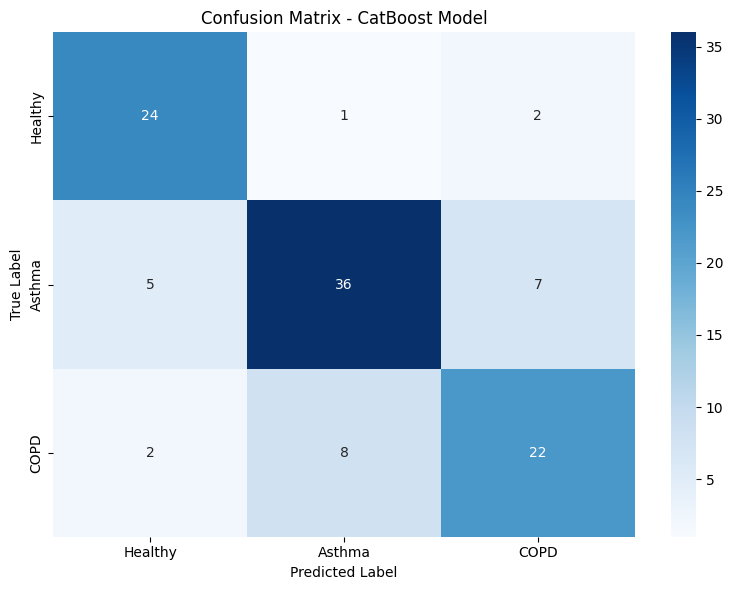


Confusion Matrix:
[[24  1  2]
 [ 5 36  7]
 [ 2  8 22]]


In [18]:
# Confusion Matrix
cm = confusion_matrix(y_test, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Healthy', 'Asthma', 'COPD'],
            yticklabels=['Healthy', 'Asthma', 'COPD'])
plt.title('Confusion Matrix - CatBoost Model')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.tight_layout()
plt.show()

print("\nConfusion Matrix:")
print(cm)

## 11. Feature Importance Analysis

In [19]:
# Get feature importance
feature_importance = catboost_model.feature_importances_

# Create feature names
n_tabular = tabular_features_imputed.shape[1]
n_cough = cough_features.shape[1]
n_vowel = vowel_features.shape[1]

feature_names = (
    list(tabular_features.columns) + 
    [f'cough_{i}' for i in range(n_cough)] +
    [f'vowel_{i}' for i in range(n_vowel)]
)

# Sort by importance
importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': feature_importance
}).sort_values('importance', ascending=False)

print("Top 20 Most Important Features:")
print(importance_df.head(20))

Top 20 Most Important Features:
                feature  importance
3       wheezingHistory   34.049511
0                   age   24.848349
1                gender    3.630251
8             packYears    3.156192
4           phlegmCough    1.070010
5   familyAsthmaHistory    0.937865
49             cough_40    0.661659
26             cough_17    0.647045
15              cough_6    0.634524
83             vowel_11    0.604552
72              vowel_0    0.550472
82             vowel_10    0.549946
73              vowel_1    0.537483
58             cough_49    0.531932
57             cough_48    0.528227
75              vowel_3    0.520726
61             cough_52    0.516362
87             vowel_15    0.508871
63             cough_54    0.498522
67             cough_58    0.482566


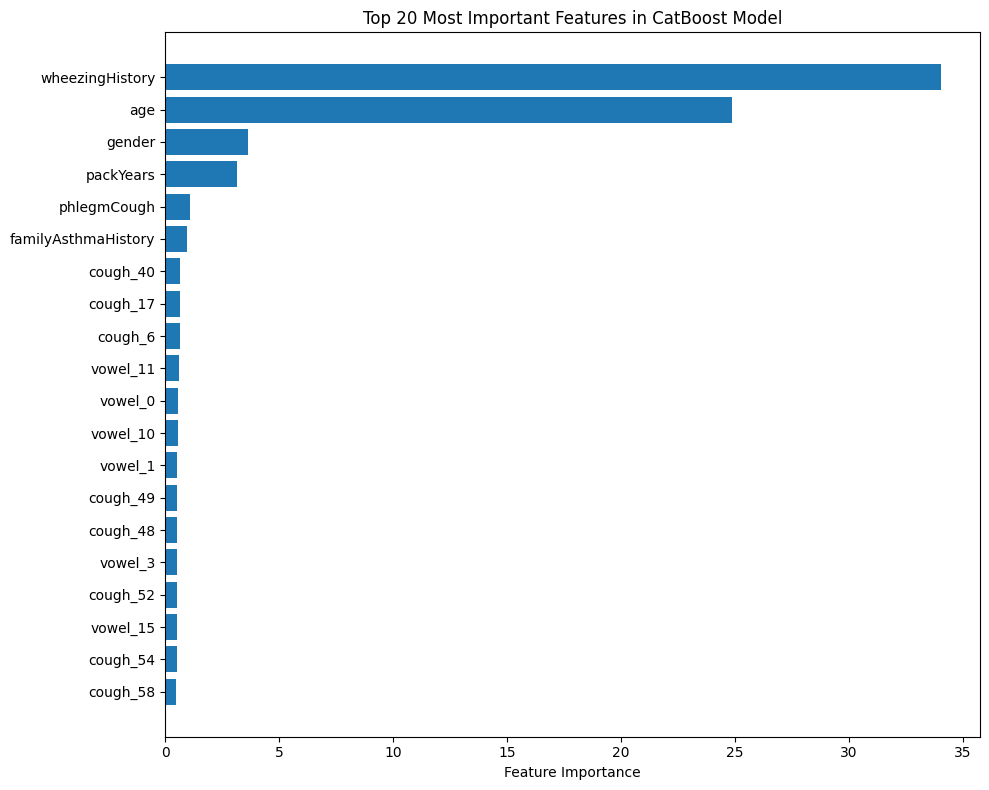

In [20]:
# Plot top 20 
plt.figure(figsize=(10, 8))
top_20 = importance_df.head(20)
plt.barh(range(len(top_20)), top_20['importance'])
plt.yticks(range(len(top_20)), top_20['feature'])
plt.xlabel('Feature Importance')
plt.title('Top 20 Most Important Features in CatBoost Model')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

## 13. Predict on Test Set (test_air_respiratory.csv)

### 13.1 Load Test CSV

In [21]:
# Load test CSV
test_csv_path = 'test_air_respiratory.csv'
df_test = pd.read_csv(test_csv_path)

print("Test Dataset Shape:", df_test.shape)
print("\nFirst 5 rows:")
print(df_test.head())
print("\nTest Data Info:")
print(df_test.info())
print("\nMissing Values:")
print(df_test.isnull().sum())

Test Dataset Shape: (338, 10)

First 5 rows:
     candidateID  age  gender  tbContactHistory  wheezingHistory  phlegmCough  \
0  136bac9a3e081   23       0               0.0              0.0          0.0   
1  b121e45942a46   26       1               0.0              0.0          0.0   
2  6b6853c07e4fb   26       1               1.0              0.0          0.0   
3  71de185eac888   55       0               0.0              0.0          0.0   
4  25deed742f133   16       0               0.0              0.0          0.0   

   familyAsthmaHistory  feverHistory  coldPresent  packYears  
0                  0.0             0          NaN          9  
1                  1.0             0          NaN          0  
2                  0.0             1          NaN          0  
3                  0.0             1          NaN          0  
4                  0.0             1          NaN          0  

Test Data Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 338 entries, 0 to 337
D

### 13.2 Match Test IDs with Audio Folders

In [22]:
# Extract test candidate IDs
test_candidate_ids = set(df_test['candidateID'].unique())
print(f"Total unique candidate IDs in test CSV: {len(test_candidate_ids)}")

# Find which test IDs have audio embeddings
test_matched_ids = test_candidate_ids.intersection(audio_candidate_ids)
print(f"Test IDs with audio embeddings: {len(test_matched_ids)}")

# IDs without embeddings
test_without_audio = test_candidate_ids - audio_candidate_ids
print(f"Test IDs WITHOUT audio embeddings: {len(test_without_audio)}")

if len(test_without_audio) > 0:
    print(f"\nWarning: {len(test_without_audio)} test candidates don't have audio embeddings!")
    print(f"We can only predict for {len(test_matched_ids)} candidates.")

Total unique candidate IDs in test CSV: 338
Test IDs with audio embeddings: 338
Test IDs WITHOUT audio embeddings: 0


### 13.3 Load Test Embeddings

In [23]:
# Load test embeddings
test_cough_embeddings = load_embeddings_for_candidates(test_matched_ids, emb_type='cough')
test_vowel_embeddings = load_embeddings_for_candidates(test_matched_ids, emb_type='vowel')

# Filter untuk kandidat yang punya BOTH embeddings
test_candidates_with_both = set(test_cough_embeddings.keys()).intersection(set(test_vowel_embeddings.keys()))
print(f"\nTest candidates with BOTH cough AND vowel embeddings: {len(test_candidates_with_both)}")


Cough Embeddings:
  - Successfully loaded: 338
  - Missing/Error: 0

Vowel Embeddings:
  - Successfully loaded: 336
  - Missing/Error: 2

Test candidates with BOTH cough AND vowel embeddings: 336

Vowel Embeddings:
  - Successfully loaded: 336
  - Missing/Error: 2

Test candidates with BOTH cough AND vowel embeddings: 336


### 13.4 Prepare Test Features

In [24]:
# Filter test dataframe untuk kandidat yang punya embeddings lengkap
df_test_filtered = df_test[df_test['candidateID'].isin(test_candidates_with_both)].copy()
print(f"Filtered test dataframe shape: {df_test_filtered.shape}")

# Sort by candidateID untuk consistency
df_test_filtered = df_test_filtered.sort_values('candidateID').reset_index(drop=True)

# Prepare tabular features (HARUS sama dengan training)
test_tabular_features = df_test_filtered.drop(columns=['candidateID'])

# Handle missing values dengan imputer yang SUDAH FIT pada training data
test_tabular_features_imputed = imputer.transform(test_tabular_features)

print(f"Test tabular features shape: {test_tabular_features_imputed.shape}")
print(f"Feature names: {list(test_tabular_features.columns)}")

Filtered test dataframe shape: (336, 10)
Test tabular features shape: (336, 9)
Feature names: ['age', 'gender', 'tbContactHistory', 'wheezingHistory', 'phlegmCough', 'familyAsthmaHistory', 'feverHistory', 'coldPresent', 'packYears']


In [25]:
# Prepare test audio embeddings
test_cough_features = []
test_vowel_features = []

for cand_id in df_test_filtered['candidateID']:
    test_cough_features.append(test_cough_embeddings[cand_id])
    test_vowel_features.append(test_vowel_embeddings[cand_id])

test_cough_features = np.array(test_cough_features)
test_vowel_features = np.array(test_vowel_features)

print(f"Test cough features shape: {test_cough_features.shape}")
print(f"Test vowel features shape: {test_vowel_features.shape}")

Test cough features shape: (336, 63)
Test vowel features shape: (336, 63)


In [26]:
# Concatenate ALL test features
X_test_combined = np.concatenate([
    test_tabular_features_imputed,
    test_cough_features,
    test_vowel_features
], axis=1)

print(f"\n=== TEST COMBINED FEATURES ===")
print(f"X_test_combined shape: {X_test_combined.shape}")
print(f"  - Tabular features: {test_tabular_features_imputed.shape[1]}")
print(f"  - Cough embeddings: {test_cough_features.shape[1]}")
print(f"  - Vowel embeddings: {test_vowel_features.shape[1]}")
print(f"  - Total features: {X_test_combined.shape[1]}")


=== TEST COMBINED FEATURES ===
X_test_combined shape: (336, 135)
  - Tabular features: 9
  - Cough embeddings: 63
  - Vowel embeddings: 63
  - Total features: 135


### 13.5 Scale Test Features

In [27]:
# Scale dengan scaler yang SUDAH FIT pada training data
X_test_final_scaled = scaler.transform(X_test_combined)

print("Test data scaled!")
print(f"X_test_final_scaled shape: {X_test_final_scaled.shape}")
print(f"X_test_final_scaled mean: {X_test_final_scaled.mean():.4f}")
print(f"X_test_final_scaled std: {X_test_final_scaled.std():.4f}")

Test data scaled!
X_test_final_scaled shape: (336, 135)
X_test_final_scaled mean: -0.0207
X_test_final_scaled std: 1.1082


### 13.6 Make Predictions!

In [29]:
# Predict menggunakan trained CatBoost model
test_predictions = catboost_model.predict(X_test_final_scaled)

# Get prediction probabilities
test_predictions_proba = catboost_model.predict_proba(X_test_final_scaled)

# Convert predictions to integers (CatBoost may return float arrays)
test_predictions = test_predictions.astype(int).flatten()

print("=== PREDICTIONS COMPLETE ===")
print(f"Total predictions: {len(test_predictions)}")
print(f"\nPrediction distribution:")
print(f"  Class 0 (Healthy): {np.sum(test_predictions == 0)}")
print(f"  Class 1 (Asthma): {np.sum(test_predictions == 1)}")
print(f"  Class 2 (COPD): {np.sum(test_predictions == 2)}")

print(f"\nFirst 10 predictions:")
for i in range(min(10, len(test_predictions))):
    cand_id = df_test_filtered['candidateID'].iloc[i]
    pred = int(test_predictions[i])
    proba = test_predictions_proba[i]
    pred_label = ['Healthy', 'Asthma', 'COPD'][pred]
    print(f"  {cand_id}: {pred_label} (prob: {proba[pred]:.3f})")

=== PREDICTIONS COMPLETE ===
Total predictions: 336

Prediction distribution:
  Class 0 (Healthy): 128
  Class 1 (Asthma): 79
  Class 2 (COPD): 129

First 10 predictions:
  004db89f19f9b: Healthy (prob: 0.863)
  007238490a3f1: COPD (prob: 0.760)
  00bcbaeb22f5f: Healthy (prob: 0.803)
  00cd3641085bc: COPD (prob: 0.865)
  00da61a101bf6: Healthy (prob: 0.509)
  01210e1ba43a5: Healthy (prob: 0.767)
  01496075be747: Asthma (prob: 0.462)
  01abb8c563412: COPD (prob: 0.760)
  01c80e004b94f: Asthma (prob: 0.962)
  01f75af556134: Healthy (prob: 0.830)


### 13.7 Handle Missing Embeddings & Create Complete Submission

**Problem**: Beberapa kandidat test tidak punya sound embeddings
**Solution**: Untuk kandidat tanpa embeddings, kita fallback ke model tabular-only atau prediksi default

In [30]:
predictions_dict = {}
for i, cand_id in enumerate(df_test_filtered['candidateID']):
    predictions_dict[cand_id] = int(test_predictions[i])

print(f"Predictions dari model CatBoost (dengan embeddings): {len(predictions_dict)}")


candidates_without_embeddings = test_candidate_ids - test_candidates_with_both
print(f"Candidates TANPA embeddings lengkap: {len(candidates_without_embeddings)}")



if len(candidates_without_embeddings) > 0:
    # Hitung distribusi prediksi
    pred_distribution = np.bincount(test_predictions)
    most_common_class = np.argmax(pred_distribution)
    
    print(f"\nFallback strategy: Assign most common predicted class = {most_common_class}")
    
    # Assign prediksi untuk kandidat tanpa embeddings
    for cand_id in candidates_without_embeddings:
        predictions_dict[cand_id] = most_common_class
    
    print(f"Total predictions after fallback: {len(predictions_dict)}")


Predictions dari model CatBoost (dengan embeddings): 336
Candidates TANPA embeddings lengkap: 2

Fallback strategy: Assign most common predicted class = 2
Total predictions after fallback: 338


In [31]:

all_predictions = []

for cand_id in df_test['candidateID']:
    if cand_id in predictions_dict:
        all_predictions.append(predictions_dict[cand_id])
    else:
        all_predictions.append(2)

# Buat submission dataframe dengan URUTAN ORIGINAL dari test CSV
final_submission_df = pd.DataFrame({
    'candidateID': df_test['candidateID'],
    'disease': all_predictions
})

print("\n" + "=" * 60)
print("FINAL SUBMISSION DATAFRAME")
print("=" * 60)
print(f"Total rows: {len(final_submission_df)}")
print(f"Expected rows: {len(df_test)} (from test CSV)")
print(f"Match: {'✅ YES' if len(final_submission_df) == len(df_test) else '❌ NO'}")

print("\nPrediction distribution:")
final_pred_counts = pd.Series(all_predictions).value_counts().sort_index()
for class_idx in [0, 1, 2]:
    class_name = ['Healthy', 'Asthma', 'COPD'][class_idx]
    count = final_pred_counts.get(class_idx, 0)
    print(f"  Class {class_idx} ({class_name}): {count}")

print("\nFirst 10 rows:")
print(final_submission_df.head(10))

print("\nLast 10 rows:")
print(final_submission_df.tail(10))

# Save to CSV with ABSOLUTE PATH
import os
submission_filename = 'submission_lightbgm_fulljere.csv'
submission_path = os.path.join(os.getcwd(), submission_filename)
final_submission_df.to_csv(submission_path, index=False)
print(f"\n✅ Submission file saved!")
print(f"   File: {submission_filename}")
print(f"   Full path: {submission_path}")
print(f"   Contains {len(final_submission_df)} predictions (all {len(df_test)} test candidates)")



FINAL SUBMISSION DATAFRAME
Total rows: 338
Expected rows: 338 (from test CSV)
Match: ✅ YES

Prediction distribution:
  Class 0 (Healthy): 128
  Class 1 (Asthma): 79
  Class 2 (COPD): 131

First 10 rows:
     candidateID  disease
0  136bac9a3e081        0
1  b121e45942a46        0
2  6b6853c07e4fb        0
3  71de185eac888        2
4  25deed742f133        0
5  1de4591779d31        0
6  102efeabb10a5        1
7  522d1f8600a13        2
8  e41530046a74e        1
9  6337b96a160eb        0

Last 10 rows:
       candidateID  disease
328  aa510e8941af7        0
329  52dd5c42e836b        2
330  00da61a101bf6        0
331  19524f5d63516        0
332  b7bb0b4e8b458        2
333  08aac13482ff8        2
334  9a8601c8de4fd        2
335  fa284742bf6a5        2
336  583f6d1a089ce        0
337  56baf88e9259b        2

✅ Submission file saved!
   File: submission_lightbgm_fulljere.csv
   Full path: c:\Users\user\Desktop\SEMESTER_3\Pembelajaran Mesin\FP_ML\submission_lightbgm_fulljere.csv
   Contains 33

In [32]:

all_predictions = []

for cand_id in df_test['candidateID']:
    if cand_id in predictions_dict:
        all_predictions.append(predictions_dict[cand_id])
    else:
        all_predictions.append(2)


final_submission_df = pd.DataFrame({
    'candidateID': df_test['candidateID'],
    'disease': all_predictions
})

print("\n" + "=" * 60)
print("FINAL SUBMISSION DATAFRAME")
print("=" * 60)
print(f"Total rows: {len(final_submission_df)}")
print(f"Expected rows: {len(df_test)} (from test CSV)")
print(f"Match: {'✅ YES' if len(final_submission_df) == len(df_test) else '❌ NO'}")

print("\nPrediction distribution:")
final_pred_counts = pd.Series(all_predictions).value_counts().sort_index()
for class_idx in [0, 1, 2]:
    class_name = ['Healthy', 'Asthma', 'COPD'][class_idx]
    count = final_pred_counts.get(class_idx, 0)
    print(f"  Class {class_idx} ({class_name}): {count}")

print("\nFirst 10 rows:")
print(final_submission_df.head(10))

print("\nLast 10 rows:")
print(final_submission_df.tail(10))

# Save to CSV with ABSOLUTE PATH
import os
submission_filename = 'submission_CatBoost_fulljere.csv'
submission_path = os.path.join(os.getcwd(), submission_filename)
final_submission_df.to_csv(submission_path, index=False)
print(f"\n✅ Submission file saved!")
print(f"   File: {submission_filename}")
print(f"   Full path: {submission_path}")
print(f"   Contains {len(final_submission_df)} predictions (all {len(df_test)} test candidates)")



FINAL SUBMISSION DATAFRAME
Total rows: 338
Expected rows: 338 (from test CSV)
Match: ✅ YES

Prediction distribution:
  Class 0 (Healthy): 128
  Class 1 (Asthma): 79
  Class 2 (COPD): 131

First 10 rows:
     candidateID  disease
0  136bac9a3e081        0
1  b121e45942a46        0
2  6b6853c07e4fb        0
3  71de185eac888        2
4  25deed742f133        0
5  1de4591779d31        0
6  102efeabb10a5        1
7  522d1f8600a13        2
8  e41530046a74e        1
9  6337b96a160eb        0

Last 10 rows:
       candidateID  disease
328  aa510e8941af7        0
329  52dd5c42e836b        2
330  00da61a101bf6        0
331  19524f5d63516        0
332  b7bb0b4e8b458        2
333  08aac13482ff8        2
334  9a8601c8de4fd        2
335  fa284742bf6a5        2
336  583f6d1a089ce        0
337  56baf88e9259b        2

✅ Submission file saved!
   File: submission_CatBoost_fulljere.csv
   Full path: c:\Users\user\Desktop\SEMESTER_3\Pembelajaran Mesin\FP_ML\submission_CatBoost_fulljere.csv
   Contains 33

### 13.8 Visualize Final Predictions (All 338 Test Samples)

In [ ]:
plt.figure(figsize=(10, 5))

plt.subplot(1, 2, 1)
final_pred_counts_sorted = final_pred_counts.reindex([0, 1, 2], fill_value=0)
plt.bar(['Healthy', 'Asthma', 'COPD'], final_pred_counts_sorted.values, color=['green', 'orange', 'red'])
plt.title(f'Final Prediction Distribution (n={len(final_submission_df)})')
plt.ylabel('Count')
plt.xlabel('Disease Class')
for i, v in enumerate(final_pred_counts_sorted.values):
    plt.text(i, v + 1, str(v), ha='center', va='bottom', fontweight='bold')

plt.subplot(1, 2, 2)
final_pred_percentages = final_pred_counts_sorted / final_pred_counts_sorted.sum() * 100
plt.bar(['Healthy', 'Asthma', 'COPD'], final_pred_percentages.values, color=['green', 'orange', 'red'])
plt.title('Final Prediction Distribution (%)')
plt.ylabel('Percentage')
plt.xlabel('Disease Class')
for i, v in enumerate(final_pred_percentages.values):
    plt.text(i, v + 1, f'{v:.1f}%', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n{'='*60}")
print(f"SUMMARY: {len(candidates_without_embeddings)} candidates without embeddings")
print(f"         were assigned class {most_common_class if 'most_common_class' in locals() else 'N/A'} (fallback strategy)")
print(f"{'='*60}")

In [ ]:
plt.figure(figsize=(12, 6))
plt.imshow(test_predictions_proba.T, aspect='auto', cmap='YlOrRd', interpolation='nearest')
plt.colorbar(label='Probability')
plt.yticks([0, 1, 2], ['Healthy', 'Asthma', 'COPD'])
plt.xlabel(f'Test Sample Index (n={len(test_predictions)} with embeddings)')
plt.ylabel('Disease Class')
plt.title('Prediction Confidence Heatmap - Samples with Audio Embeddings')
plt.tight_layout()
plt.show()

print("\nAverage confidence per class (samples with embeddings):")
for i, class_name in enumerate(['Healthy', 'Asthma', 'COPD']):
    avg_conf = test_predictions_proba[:, i].mean()
    print(f"  {class_name}: {avg_conf:.3f}")
    
print(f"\nNote: {len(candidates_without_embeddings)} samples without embeddings")
print(f"      were assigned default predictions (not shown in heatmap)")